# Issue Inspection - Linkage

## Prep

In [34]:
import yaml
import spacy
import numpy as np
import pandas as pd
from typing import *
from functools import partial
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster

cfg = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)
model = SentenceTransformer("multi-qa-mpnet-base-cos-v1")
nlp = spacy.load("en_core_web_sm")

def __dist__(A: np.ndarray, B: np.ndarray, n_segments: int, lamda: float = 0.5) -> float:
    if lamda > 0:                                               # include position
        A_pos, B_pos = int(A[0]), int(B[0])
        pos_dist = abs(A_pos - B_pos)                           # integer [1, n_segments]
        pos_dist_norm = pos_dist / n_segments                   # float [0, 1]
        A_vec, B_vec = A[1:], B[1:]
    else:                                                       # exclude position
        pos_dist_norm = 0
        A_vec, B_vec = A, B
    cos_sim = np.dot(A_vec, B_vec) / (np.linalg.norm(A_vec) * np.linalg.norm(B_vec))
    cos_dist = 1 - cos_sim                                      # float [0, 2]
    cos_dist_norm = cos_dist / 2                                # float [0, 1]
    return lamda * pos_dist_norm + (1-lamda) * cos_dist_norm    # float [0, 1]

def split_sentences(doc: str):
    return [text.text.strip() for segment in doc.split("\n") for text in nlp(segment).sents]

def group_by_cluster(texts, labels):
    df = pd.DataFrame({"label": labels, "texts": texts})
    df = df.groupby("label")["texts"].apply(lambda x: '\n'.join(x)).reset_index()
    return df["texts"].tolist(), df["label"].tolist()

def log_clusters(texts, ids):
    for text, id in zip(texts, ids):
        cluster_id = id.split('|')[1]
        print(f'Cluster ID: {cluster_id}')
        print(f'Text: {text}')
        print()

### k-split

Given a document, k-split clusters the sentences into a fixed number of semantically similar chunks following single-linkage clustering:
1. Split the document into sentences.
2. Get sentence embeddings.
3. Calculate distance matrix, where each entry is the distance between the row-index sentence embedding and the column-index sentence embedding.
4. Obtain linkage matrix via `scipy.cluster.hierarchy.linkage`, which is a $(n-1)\times4$ array.
    - Each row represents a linkage between 2 clusters.
    - The first 2 columns represents the 2 clusters being linked.
    - The third column represents the minimal distance between the 2 clusters.
    - The fourth column represents the number of samples in the combined cluster.
    - All rows are sorted in the ascending order of distance. The formation of clusters follow the same order as the rows.
        - For example, given an array of data points [1,2,5,7],
            1. 1 and 2 are linked first.
            2. 5 and 7 are linked second.
            3. 2 and 5 are linked last.
5. Form clusters based on the order specified by the linkage matrix till the desired number of clusters is reached.

In [35]:
def single_linkage_clustering_k_split(data: np.ndarray, lamda: float = 0., n_clusters: int = 10):
    metric = partial(__dist__, n_segments=len(data), lamda=lamda)
    distance_matrix = np.abs(pdist(data, metric=metric))
    linkage_matrix = linkage(distance_matrix, method='single')
    cluster_labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    return cluster_labels

def cluster_chunker_k_split(doc: str, doc_id: str, lamda: float = 0., n_clusters: int = 10):
    sents = split_sentences(doc)
    embs = model.encode(sents)
    if lamda > 0: embs = np.insert(embs, 0, range(len(embs)), axis=1)     # insert position in front of semantic embeddings
    labels = single_linkage_clustering_k_split(embs, n_clusters=n_clusters)
    texts, ids = group_by_cluster(sents, labels)
    ids = ["{}|{}".format(doc_id, cluster_id) for cluster_id in ids]
    return texts, ids

### k-preserve

Given a document, k-preserve clusters the sentences into semantically similar chunks, where each clusters must have a minimal number of samples:
1. Split the document into sentences.
2. Get sentence embeddings.
3. Calculate distance matrix, where each entry is the distance between the row-index sentence embedding and the column-index sentence embedding.
4. Obtain linkage matrix via `scipy.cluster.hierarchy.linkage`, which is a $(n-1)\times4$ array.
    - Each row represents a linkage between 2 clusters.
    - The first 2 columns represents the 2 clusters being linked.
    - The third column represents the minimal distance between the 2 clusters.
    - The fourth column represents the number of samples in the combined cluster.
    - All rows are sorted in the ascending order of distance. The formation of clusters follow the same order as the rows.
        - For example, given an array of data points [1,2,5,7],
            1. 1 and 2 are linked first.
            2. 5 and 7 are linked second.
            3. 2 and 5 are linked last.
5. Form clusters based on the order specified by the linkage matrix till the desired number of clusters is reached.
    - Here, the desired number of clusters is initialized as the number of samples divided by the minimal number of samples per cluster.
6. Iterate till every cluster has the required minimal number of samples:
    1. Find the small clusters with less than the minimum threshold.
    2. Find the closest cluster for each small cluster to merge with.
    3. Relabel the merged clusters.
    4. Break when there's no more small cluster.

In [36]:
def single_linkage_clustering_k_preserve(data: np.ndarray, lamda: float = 0., min_samples: Optional[int] = None):
    if min_samples is None:
        min_samples = len(data) // 10 + 1
    if min_samples > len(data)/2:
        min_samples = len(data) // 10 + 1
    n_clusters = len(data)//min_samples      # k-preserve initializes with total number of segments as n_clusters

    # perform single-linkage clustering with n_clusters first
    metric = partial(__dist__, n_segments=len(data), lamda=lamda)
    distance_matrix = np.abs(pdist(data, metric=metric))
    linkage_matrix = linkage(distance_matrix, method='single')
    cluster_labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

    while True:
        # find the small clusters with less than min_samples
        unique_labels, counts = np.unique(cluster_labels, return_counts=True)
        small_clusters = unique_labels[counts < min_samples]
        small_counts = counts[counts < min_samples]

        # if no small clusters, break
        if len(small_clusters) == 0:
            break

        # find the smallest cluster to merge
        smallest_cluster = small_clusters[np.argmin(small_counts)]
        smallest_indices = np.where(cluster_labels == smallest_cluster)[0]

        # find the closest cluster to merge with
        min_distance = np.inf
        closest_cluster = None
        distance_square = squareform(distance_matrix)
        for i in smallest_indices:
            distances = distance_square[i]
            for lbl in unique_labels:
                if lbl != smallest_cluster:
                    cluster_indices = np.where(cluster_labels == lbl)[0]
                    mean_distance = np.mean(distances[cluster_indices])
                    if mean_distance < min_distance:
                        min_distance = mean_distance
                        closest_cluster = lbl

        # merge the smallest cluster with the closest cluster
        cluster_labels[cluster_labels == smallest_cluster] = closest_cluster

    # relabel clusters consecutively
    unique_labels = np.unique(cluster_labels)
    new_labels = np.zeros_like(cluster_labels)
    for new_label, unique_label in enumerate(unique_labels, start=1):
        new_labels[cluster_labels == unique_label] = new_label

    return new_labels

def cluster_chunker_k_preserve(doc: str, doc_id: str, lamda: float = 0., min_samples: Optional[int] = None):
    sents = split_sentences(doc)
    embs = model.encode(sents)
    if lamda > 0: embs = np.insert(embs, 0, range(len(embs)), axis=1)     # insert position in front of semantic embeddings
    labels = single_linkage_clustering_k_preserve(embs, lamda=lamda, min_samples=min_samples)
    texts, ids = group_by_cluster(sents, labels)
    ids = ["{}|{}".format(doc_id, cluster_id) for cluster_id in ids]
    return texts, ids

### constrained single-linkage clustering

Given a document, constrained version clusters the sentences into semantically similar chunks, where each clusters cannot exceed the maximal number of samples requirement:
1. Split the document into sentences.
2. Get sentence embeddings.
3. Calculate distance matrix, where each entry is the distance between the row-index sentence embedding and the column-index sentence embedding.
4. Iterate through the distance matrix to form clusters till all distances are checked:
    1. Find the pair of samples with minimal distance.
    2. Find the clusters each one belongs to.
    3. Check if the combined cluster would exceed the maximum sample size threshold.
        - If yes, ignore this linkage.
        - If no, merge.
    4. Relabel the merged clusters.
    5. Break after all distances are checked.

In [37]:
from retriever import get_encoder

def get_dist_mat(data: np.ndarray, lamda: float = 0.5) -> np.ndarray:
    return np.triu(squareform(np.abs(pdist(data, metric=partial(__dist__, n_segments=len(data), lamda=lamda)))))

def get_curr_min_idx(arr: np.ndarray):
    return np.argmin(arr)//len(arr), np.argmin(arr)%len(arr)

def single_linkage_clustering(embs: np.ndarray, lamda: float = 0.5, max_samples_per_cluster: Optional[int] = None):
    # get distance matrix
    dist_mat = get_dist_mat(embs, lamda=lamda)
    dist_mat[dist_mat == 0] = float('inf')  # set diagonal to infinity so that the minimum value can be iterated

    # set max_samples_per_cluster
    if not max_samples_per_cluster: max_samples_per_cluster = len(embs) // 10

    # initialize clusters and parents
    clusters = {i: [i] for i in range(len(embs))}
    parents = {i: i for i in range(len(embs))}

    # iterate through the distance matrix from min to max for single linkage clustering
    while dist_mat.min() < float('inf'):
        row, col = get_curr_min_idx(dist_mat)
        parent_row, parent_col = parents[row], parents[col]
        if parent_row != parent_col and len(clusters[parent_row]) + len(clusters[parent_col]) <= max_samples_per_cluster:
            clusters[parent_row].extend(clusters[parent_col])
            for sample in clusters[parent_col]:
                parents[sample] = parent_row
            del clusters[parent_col]
        dist_mat[row, col] = float('inf')

    # convert parents to cluster labels
    parent_to_cluster_label = {}
    temp_lbl = 0
    for parent in parents.values():
        if parent not in parent_to_cluster_label:
            parent_to_cluster_label[parent] = temp_lbl
            temp_lbl += 1

    # get cluster labels for all samples
    cluster_labels = [parent_to_cluster_label[parents[idx]] for idx in range(len(embs))]

    return cluster_labels

def cluster_chunker(doc, doc_id, encoder = None, lamda: float = 0., max_samples_per_cluster: Optional[int] = None):
    if not encoder: raise ValueError("Encoder is required for cluster_chunker")
    sents = split_sentences(doc)
    embs = encoder.embed_documents(sents)
    labels = single_linkage_clustering(embs, lamda=lamda, max_samples_per_cluster=max_samples_per_cluster)
    texts, ids = group_by_cluster(sents, labels)
    ids = ["{}|{}".format(doc_id, cluster_id) for cluster_id in ids]
    return texts, ids

## Example: Short document with clear semantic difference

The first 3 sentences are about tasty food.

The second 3 sentences are about computer science.

The last 4 sentences are about psychology.

We randomly mix them and see how it goes.

In [38]:
doc = [
    "The dish was incredibly flavorful and satisfying.",
    "The meal had a rich, delightful taste.",
    "The food was packed with delicious flavors.",
    "The algorithm efficiently solves the problem.",
    "The program runs with optimal performance.",
    "The code executes with high efficiency.",
    "Human behavior is influenced by various cognitive processes.",
    "Mental processes play a key role in shaping actions.",
    "Thoughts and emotions impact how people behave.",
    "Behavior is closely linked to psychological factors.",
]

import random
random.seed(0)
random.shuffle(doc)
doc = ' '.join(doc)

In [39]:
texts, ids = cluster_chunker_k_split(doc, doc_id="doc0", n_clusters=3)
print("K-split Chunker")
log_clusters(texts, ids)

K-split Chunker
Cluster ID: 1
Text: Mental processes play a key role in shaping actions.
Thoughts and emotions impact how people behave.
Behavior is closely linked to psychological factors.
Human behavior is influenced by various cognitive processes.

Cluster ID: 2
Text: The meal had a rich, delightful taste.
The food was packed with delicious flavors.
The dish was incredibly flavorful and satisfying.

Cluster ID: 3
Text: The code executes with high efficiency.
The algorithm efficiently solves the problem.
The program runs with optimal performance.



In [40]:
texts, ids = cluster_chunker_k_preserve(doc, doc_id="doc0", min_samples=3)
print("K-preserve Chunker")
log_clusters(texts, ids)

K-preserve Chunker
Cluster ID: 1
Text: Mental processes play a key role in shaping actions.
Thoughts and emotions impact how people behave.
Behavior is closely linked to psychological factors.
Human behavior is influenced by various cognitive processes.

Cluster ID: 2
Text: The meal had a rich, delightful taste.
The food was packed with delicious flavors.
The dish was incredibly flavorful and satisfying.

Cluster ID: 3
Text: The code executes with high efficiency.
The algorithm efficiently solves the problem.
The program runs with optimal performance.



In [41]:
texts, ids = cluster_chunker(doc, doc_id="doc0", encoder=get_encoder("huggingface"), max_samples_per_cluster=4)
print("Constrained single-linkage Chunker")
log_clusters(texts, ids)

Constrained single-linkage Chunker
Cluster ID: 0
Text: Mental processes play a key role in shaping actions.
Thoughts and emotions impact how people behave.
Behavior is closely linked to psychological factors.
Human behavior is influenced by various cognitive processes.

Cluster ID: 1
Text: The meal had a rich, delightful taste.
The food was packed with delicious flavors.
The dish was incredibly flavorful and satisfying.

Cluster ID: 2
Text: The code executes with high efficiency.
The algorithm efficiently solves the problem.
The program runs with optimal performance.



As shown above, there's no clear difference. All 3 clustering algorithms were able to distinguish between food, computer science, and psychology, because the sentences are semantically very different. The pattern is quite obvious.

Let's take a look at the dendrogram for k-split. (I cannot get dendrogram for k-preserve or constrained single-linkage because they are written from scratch.)

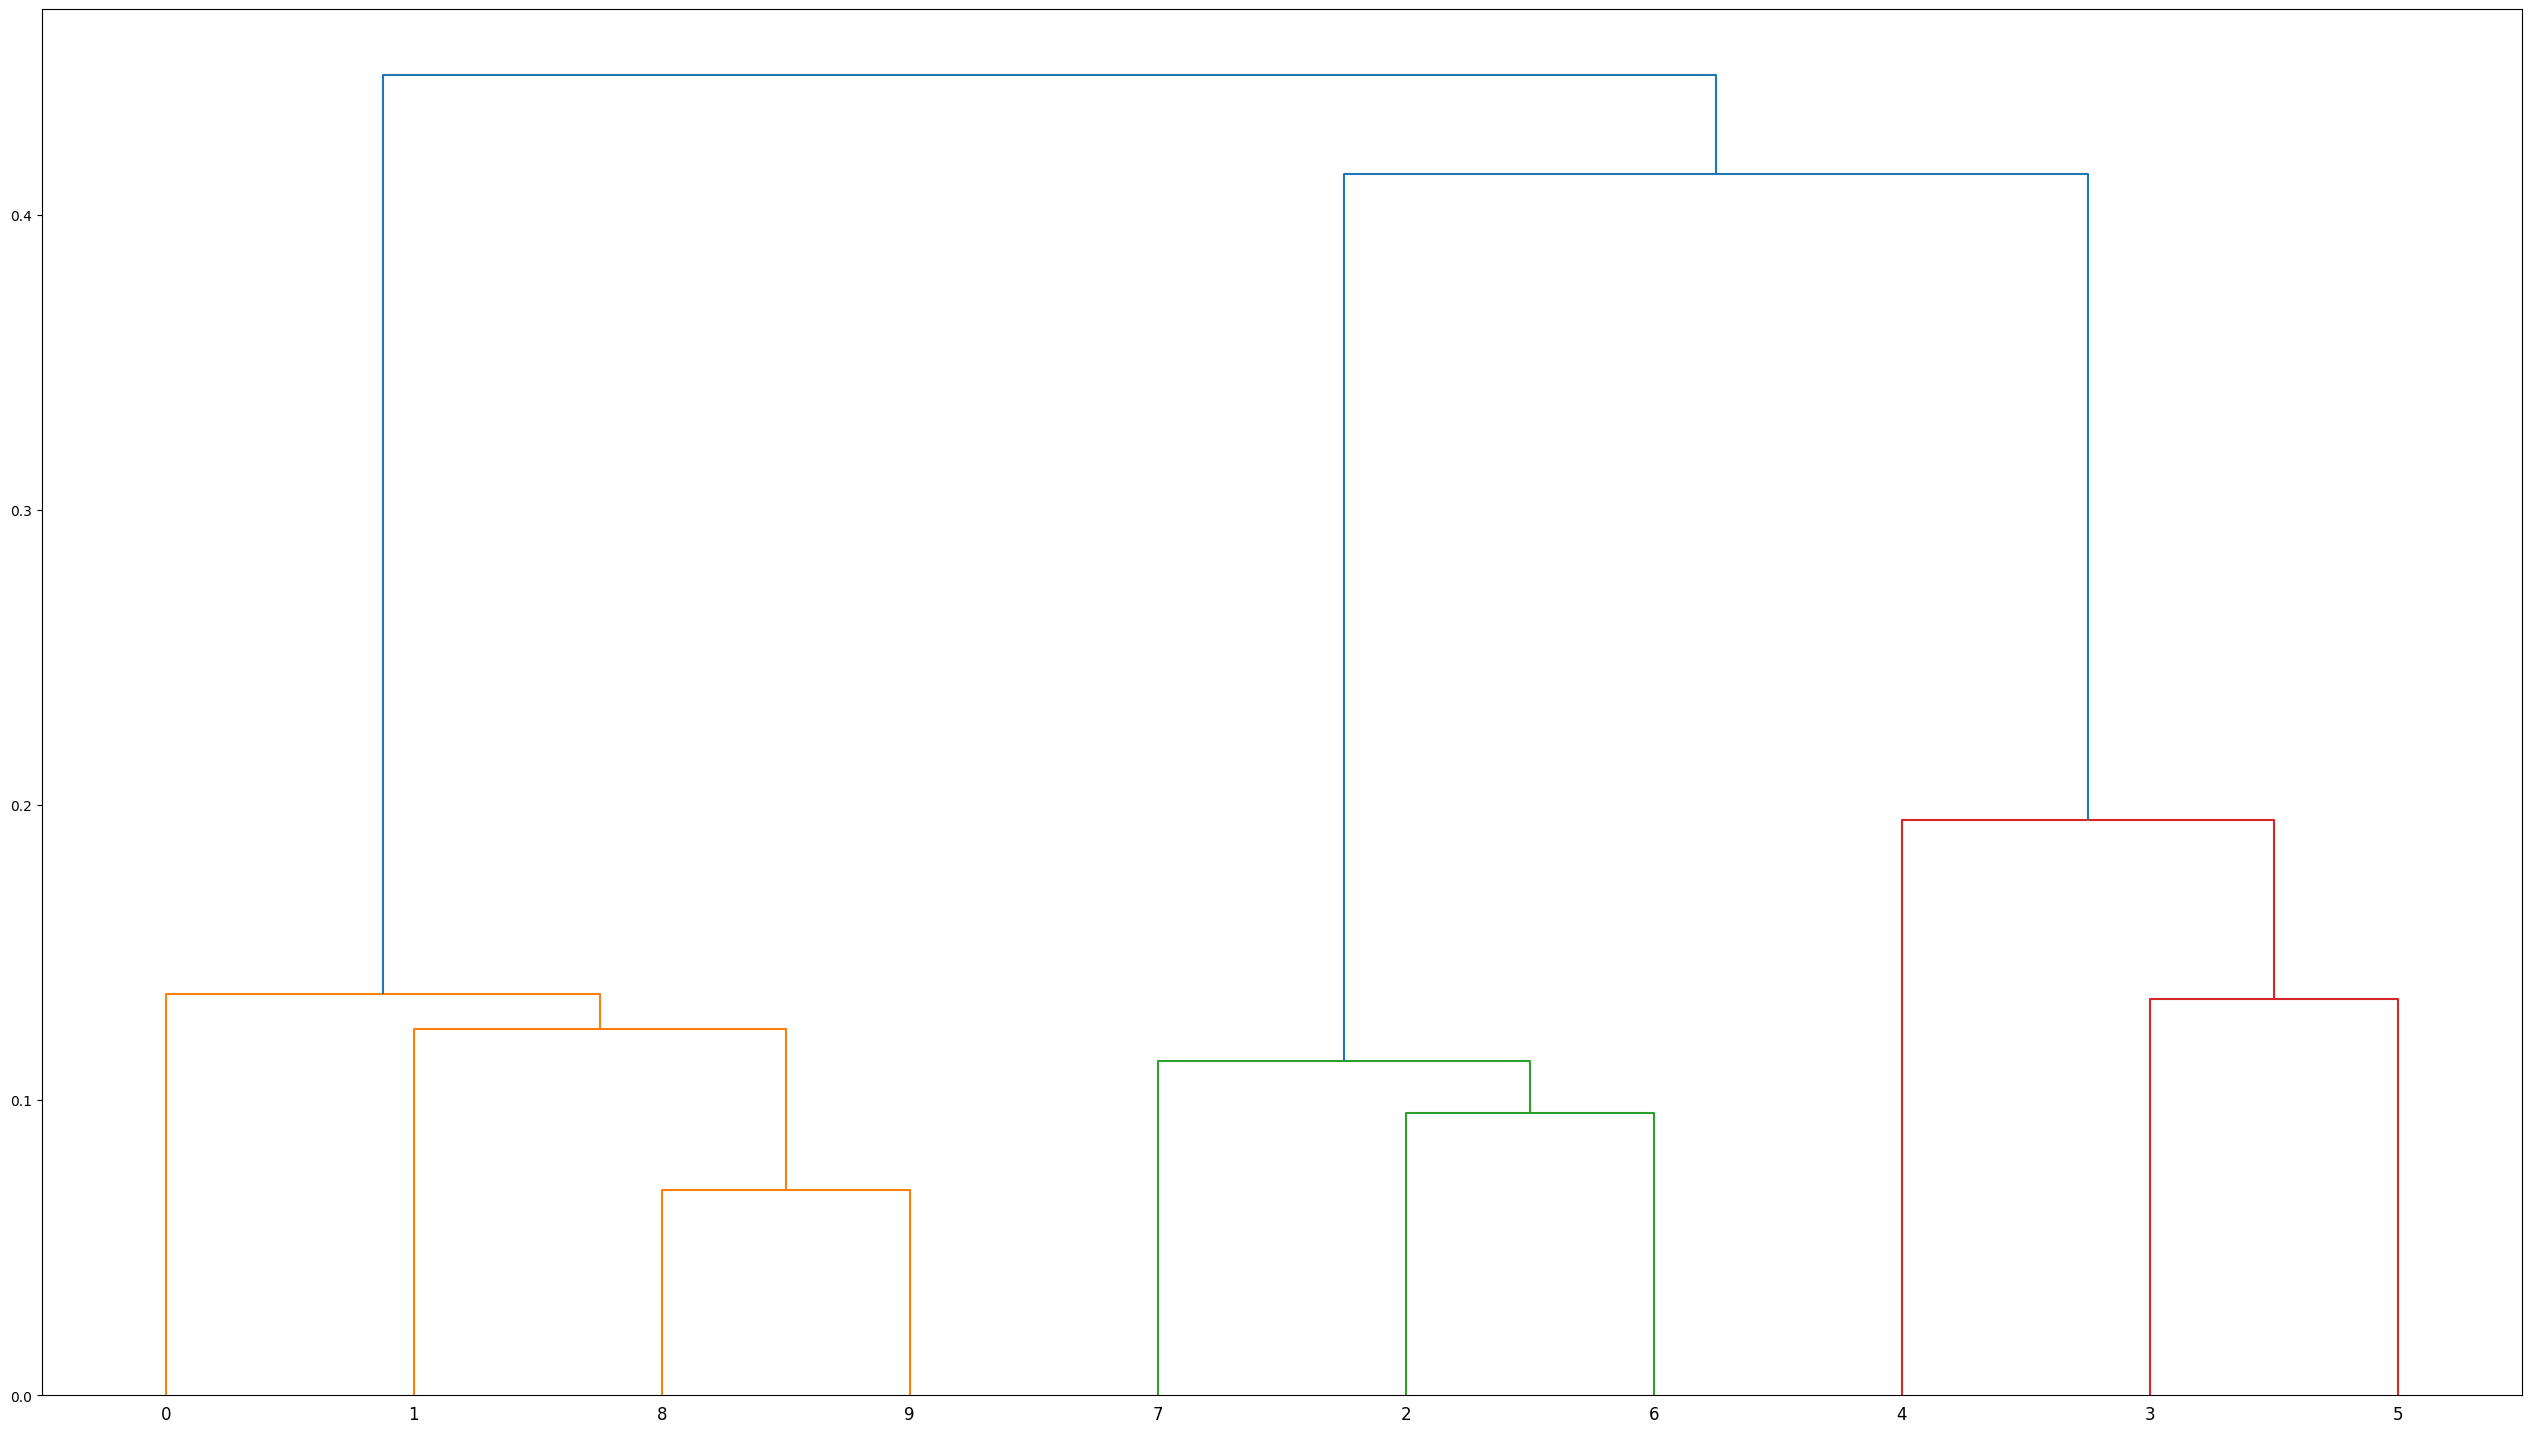

In [42]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

sents = split_sentences(doc)
embs = model.encode(sents)
metric = partial(__dist__, n_segments=len(embs), lamda=0)
distance_matrix = np.abs(pdist(embs, metric=metric))
linkage_matrix = linkage(distance_matrix, method='single')
dendrogram(linkage_matrix)
plt.rcParams["figure.figsize"] = (32, 18)
plt.show()

Although there seems to be no problem so far, the issue is going to be apparent in the next sample. Pay close attention to the blue linkage.

## Example: Short document with no clear semantic difference

We ask ChatGPT to randomly generate a paragraph of 10 sentences on the fusion between food, computer science, and psychology.

Let's see how it goes.

In [43]:
doc = "In the intricate world of human experience, the interplay between food, computer science, and psychology reveals fascinating insights into how we perceive and interact with our environment. Just as a carefully prepared meal satisfies our taste buds and nourishes our bodies, well-designed algorithms in computer science cater to the needs of efficiency and performance, ensuring that complex problems are solved with precision. The psychology behind our food choices, influenced by cognitive processes like memory and emotion, mirrors the way we approach problem-solving in computer science, where past experiences and emotional states can affect decision-making. Furthermore, the way we program machines to understand and predict human behavior through artificial intelligence draws a parallel to how our brains process and respond to sensory input, like the taste and aroma of food. This convergence of fields highlights the complexity of human cognition, where the satisfaction of a meal, the efficiency of a program, and the intricacies of mental processes all contribute to our understanding of the world and ourselves. Building on these connections, the relationship between these fields becomes even more profound when we consider the role of data in shaping our experiences. In computer science, data drives the development of algorithms that can predict preferences, much like how our psychological history and sensory memories guide our food choices. For example, machine learning models analyze vast amounts of data to recommend recipes based on individual tastes, effectively merging the computational with the culinary. Similarly, psychology helps us understand why certain foods provide comfort or evoke memories, offering insights into how data can be used to mimic these emotional responses in artificial systems. As we continue to explore these intersections, the potential for innovation grows—whether it's creating personalized nutrition plans based on psychological profiles or developing more intuitive AI systems that understand the nuances of human behavior."

len(split_sentences(doc))

10

In [44]:
texts, ids = cluster_chunker_k_split(doc, doc_id="doc0", n_clusters=3)
print("K-split Chunker")
log_clusters(texts, ids)

K-split Chunker
Cluster ID: 1
Text: In the intricate world of human experience, the interplay between food, computer science, and psychology reveals fascinating insights into how we perceive and interact with our environment.
Just as a carefully prepared meal satisfies our taste buds and nourishes our bodies, well-designed algorithms in computer science cater to the needs of efficiency and performance, ensuring that complex problems are solved with precision.
The psychology behind our food choices, influenced by cognitive processes like memory and emotion, mirrors the way we approach problem-solving in computer science, where past experiences and emotional states can affect decision-making.
Furthermore, the way we program machines to understand and predict human behavior through artificial intelligence draws a parallel to how our brains process and respond to sensory input, like the taste and aroma of food.
In computer science, data drives the development of algorithms that can predict

In [45]:
texts, ids = cluster_chunker_k_preserve(doc, doc_id="doc0", min_samples=3)
print("K-preserve Chunker")
log_clusters(texts, ids)

K-preserve Chunker
Cluster ID: 1
Text: In the intricate world of human experience, the interplay between food, computer science, and psychology reveals fascinating insights into how we perceive and interact with our environment.
Just as a carefully prepared meal satisfies our taste buds and nourishes our bodies, well-designed algorithms in computer science cater to the needs of efficiency and performance, ensuring that complex problems are solved with precision.
The psychology behind our food choices, influenced by cognitive processes like memory and emotion, mirrors the way we approach problem-solving in computer science, where past experiences and emotional states can affect decision-making.
Furthermore, the way we program machines to understand and predict human behavior through artificial intelligence draws a parallel to how our brains process and respond to sensory input, like the taste and aroma of food.
This convergence of fields highlights the complexity of human cognition, whe

In [46]:
texts, ids = cluster_chunker(doc, doc_id="doc0", encoder=get_encoder("huggingface"), max_samples_per_cluster=4)
print("Constrained single-linkage Chunker")
log_clusters(texts, ids)

Constrained single-linkage Chunker
Cluster ID: 0
Text: In the intricate world of human experience, the interplay between food, computer science, and psychology reveals fascinating insights into how we perceive and interact with our environment.
The psychology behind our food choices, influenced by cognitive processes like memory and emotion, mirrors the way we approach problem-solving in computer science, where past experiences and emotional states can affect decision-making.
In computer science, data drives the development of algorithms that can predict preferences, much like how our psychological history and sensory memories guide our food choices.
Similarly, psychology helps us understand why certain foods provide comfort or evoke memories, offering insights into how data can be used to mimic these emotional responses in artificial systems.

Cluster ID: 1
Text: Just as a carefully prepared meal satisfies our taste buds and nourishes our bodies, well-designed algorithms in computer s

The problem is now obvious:
- k-split managed to meet the number of clusters requirement by grouping most sentences into a huge chunk and leaving other sentences behind.
- k-preserve managed to meet the minimal cluster sample size requirement by grouping all sentences into a huge chunk.
- constrained single-linkage did an excellent job by forming clusters of similar sample sizes.

Let's take a look at the dendrogram for k-split.

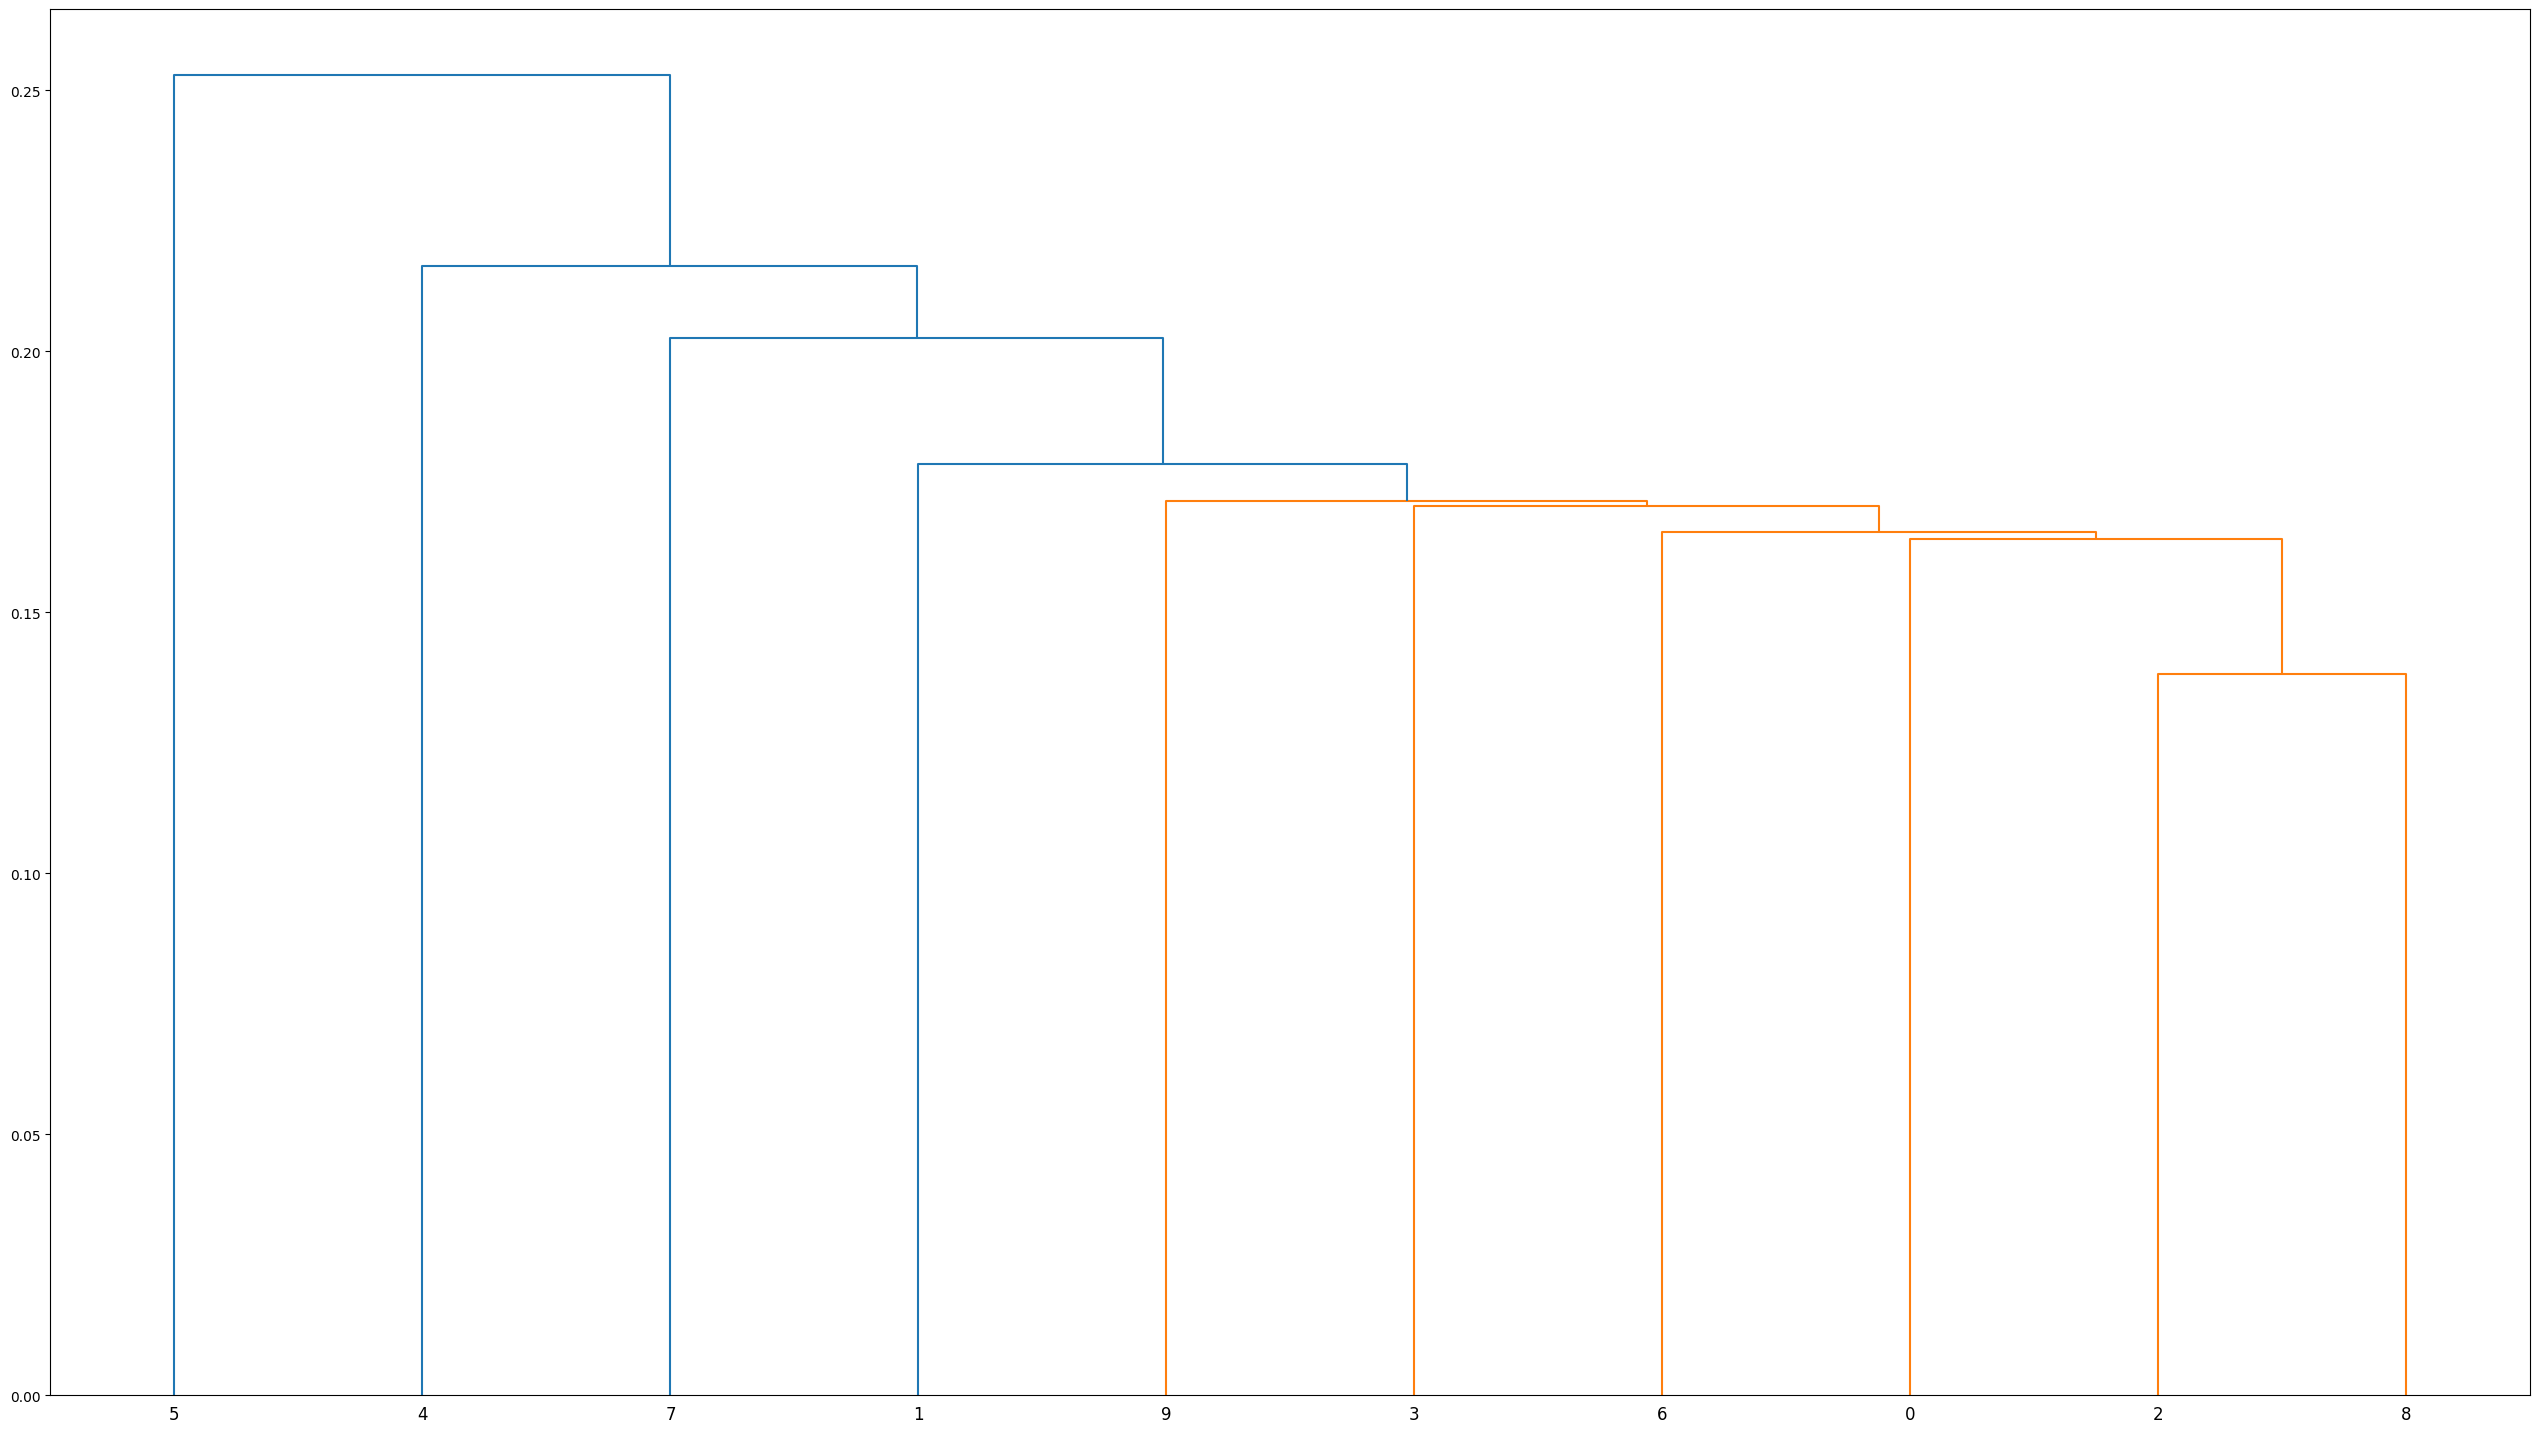

In [47]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

sents = split_sentences(doc)
embs = model.encode(sents)
metric = partial(__dist__, n_segments=len(embs), lamda=0)
distance_matrix = np.abs(pdist(embs, metric=metric))
linkage_matrix = linkage(distance_matrix, method='single')
dendrogram(linkage_matrix)
plt.rcParams["figure.figsize"] = (32, 18)
plt.show()

As shown above, k-split will form the clusters AFTER going through the entire linkage matrix (bottom-up), then attempt to meet the required number of clusters backwards (top-down). This leads to sample 5 and sample 4 being left behind, while other sentences getting grouped together.

The output below is identical to that from the single-sentence clusters from k-split above.

In [50]:
sents = split_sentences(doc)
print(f"Sentence 4: {sents[4]}")
print()
print(f"Sentence 5: {sents[5]}")

Sentence 4: This convergence of fields highlights the complexity of human cognition, where the satisfaction of a meal, the efficiency of a program, and the intricacies of mental processes all contribute to our understanding of the world and ourselves.

Sentence 5: Building on these connections, the relationship between these fields becomes even more profound when we consider the role of data in shaping our experiences.


In [49]:
texts, ids = cluster_chunker_k_split(doc, doc_id="doc0", n_clusters=3)
print("K-split Chunker")
log_clusters(texts, ids)

K-split Chunker
Cluster ID: 1
Text: In the intricate world of human experience, the interplay between food, computer science, and psychology reveals fascinating insights into how we perceive and interact with our environment.
Just as a carefully prepared meal satisfies our taste buds and nourishes our bodies, well-designed algorithms in computer science cater to the needs of efficiency and performance, ensuring that complex problems are solved with precision.
The psychology behind our food choices, influenced by cognitive processes like memory and emotion, mirrors the way we approach problem-solving in computer science, where past experiences and emotional states can affect decision-making.
Furthermore, the way we program machines to understand and predict human behavior through artificial intelligence draws a parallel to how our brains process and respond to sensory input, like the taste and aroma of food.
In computer science, data drives the development of algorithms that can predict